In [ ]:
#| output: false
%load_ext autoreload
%autoreload 2

Necessary imports

In [ ]:
# creating graphs in Python
import networkx as nx
# calling git commands
import subprocess
# checking for existence of paths, and manipulating paths
from pathlib import Path

## Cloning git.git repository, and extracting and saving the commit graph

Why it is important to use sparse clone - it is much faster, and takes up less space.  For example for git.git repository we have the following (all times are wall time, and subject to interference from other CPU load):
- full clone: 54s
- mirror: 1min 19s
- sparse: 14.9s - 19.4s

Prepare the directory to store repositories (note: `mkdir -d <directory>` should show no error if `<directory>` exists, but it is not portable).

Clone example repository (for exploration).  Might give errors if repository already exists.

In [ ]:
# create the directory to store cloned repositories, if it does not exist
Path("repos").mkdir(exist_ok=True)

In [ ]:
%%time
!git -C repos clone --mirror --filter=tree:0 --quiet https://github.com/git/git.git

Wall time: 1.05 s


fatal: destination path 'git.git' already exists and is not an empty directory.


Extract the history of the project

In [ ]:
# create the directory to store datasets
Path("datasets").mkdir(exist_ok=True)

In [ ]:
%%time
!git -C repos/git.git log --format="%h %p" --topo-order --branches >datasets/git-commit_graph.adjlist.txt

Wall time: 6.81 s


It takes a few seconds on a laptop with HDD to extract the commit graph (for all branches), storing results in a `git-commit_graph.adjlist.txt` text file in the adjacent list format in `datasets/` subdirectory

In [ ]:
%%time
graph_git = nx.read_adjlist("datasets/git-commit_graph.adjlist.txt", create_using=nx.DiGraph)

Wall time: 663 ms


It takes less than a second to create NetworkX graph for a commit graph

In [ ]:
print('commit-graph of git repository graph has {} nodes and {} edges'.format(
      graph_git.number_of_nodes(),
      graph_git.number_of_edges()))
print('is directed:   {}'.format(graph_git.is_directed()))
print('is DAG:        {}'.format(nx.is_directed_acyclic_graph(graph_git)))
print('example nodes: {}'.format(list(graph_git.nodes)[:5]))

commit-graph of git repository graph has 63829 nodes and 79664 edges
is directed:   True
is DAG:        True
example nodes: ['836aadd78', 'a93475d10', '55fce44a3', '6d9d59c31', '084bd2a9a']


In [ ]:
# compress
%timeit nx.write_adjlist(graph_git, 'datasets/git-commit_graph.adjlist.txt.gz')

403 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes around 0.6-0.8 seconds to write it back gzip-compressed in the adjacency list format as `git-commit_graph.adjlist.txt.gz`

### Testing different graph output formats

In [ ]:
#%%time
#nx.write_graph6(graph_git, 'datasets/git-commit_graph.g6')

It turns out that the [graph6 / sparse6 format](https://networkx.org/documentation/stable/reference/readwrite/sparsegraph6.html)
is not a good choice for storing the commit graph for the following reasons:
- NetworkX does not support digraph6 format; neither `write_graph6` not `write_sparse6` are implemented for directed graphs
- the [digraph6 format](http://users.cecs.anu.edu.au/~bdm/data/formats.txt) is dense graph format, storing the encoded adjacency matrix; there is no disparse6 or digraph6sparse format
- SparseGraph6 formats do not store node/vertex names, which might be needed for future computations or visualizations

In [ ]:
import pickle

In [ ]:
print('edgelist.txt:            ', end=' ', flush=True)
%time nx.write_edgelist(graph_git, 'datasets/git-commit_graph.edgelist.txt')
print('multiline_adjlist.txt:   ', end=' ', flush=True)
%time nx.write_multiline_adjlist(graph_git, 'datasets/git-commit_graph.multiline_adjlist.txt')
print('edgelist.txt.gz:         ', end=' ', flush=True)
%time nx.write_edgelist(graph_git, 'datasets/git-commit_graph.edgelist.txt.gz')
print('multiline_adjlist.txt.gz:', end=' ', flush=True)
%time nx.write_multiline_adjlist(graph_git, 'datasets/git-commit_graph.multiline_adjlist.txt.gz')
print('gexf.gz:                 ', end=' ', flush=True)
%time nx.write_gexf(graph_git, 'datasets/git-commit_graph.gexf.gz')
print('graphml.gz:              ', end=' ', flush=True)
%time nx.write_graphml(graph_git, 'datasets/git-commit_graph.graphml.gz')
print('pajek.gz:                ', end=' ', flush=True)
%time nx.write_pajek(graph_git, 'datasets/git-commit_graph.pajek.gz')

edgelist.txt:             Wall time: 244 ms
multiline_adjlist.txt:    Wall time: 186 ms
edgelist.txt.gz:          Wall time: 819 ms
multiline_adjlist.txt.gz: Wall time: 1.06 s
gexf.gz:                  Wall time: 5.34 s
graphml.gz:               Wall time: 5.01 s
pajek.gz:                 Wall time: 3.14 s


In [ ]:
#print('gpickle.gz:              ', end=' ', flush=True)
#%time nx.write_gpickle(graph_git, 'datasets/git-commit_graph.gpickle.gz')  # removed in NetworkX 3.x

gpickle.gz:               

In [ ]:
%%time
print('gpickle.gz:              ', end=' ', flush=True)
with open('datasets/git-commit_graph.gpickle.gz', 'wb') as f:
    pickle.dump(graph_git, f, pickle.HIGHEST_PROTOCOL)

gpickle.gz:               Wall time: 273 ms


In [ ]:
import pandas as pd

In [ ]:
graph_git_df = nx.to_pandas_edgelist(graph_git)
graph_git_df

,source,target
0,836aadd78,a93475d10
1,836aadd78,55fce44a3
2,a93475d10,df525e622
3,55fce44a3,6d9d59c31
4,6d9d59c31,084bd2a9a
...,...,...
79659,24778e335,19b2860cb
79660,19b2860cb,bf0c6e839
79661,bf0c6e839,e497ea2a9
79662,e497ea2a9,8bc9a0c76


In [ ]:
%%time
graph_git_df.to_pickle('datasets/git-commit_graph.df_edgelist.pickle.gz')

Wall time: 1.07 s


In [ ]:
%%time
graph_git_df.to_csv('datasets/git-commit_graph.df_edgelist.csv.gz')

Wall time: 1.04 s


Both `to_feather()` and `to_parquet()` need `pyarrow` module installed (the latter might use `fastparquet` instead)

In [ ]:
%%time
try:
    graph_git_df.to_feather('datasets/git-commit_graph.df_edgelist.feather')
except ImportError:
    print("Missing optional dependency 'pyarrow' required to save dataframe to the feather format")

Wall time: 587 ms


In [ ]:
%%time
try:
    graph_git_df.to_parquet('datasets/git-commit_graph.df_edgelist.parquet')
except ImportError:
    print("Missing optional dependency 'pyarrow' or 'fastparquet' required to save dataframe to the parquet format")

Wall time: 1.18 s


`to_hdf()` needs `tables` module installed (PyTables).

In [ ]:
%%time
try:
    graph_git_df.to_hdf('datasets/git-commit_graph.df_edgelist.hdf5', 'df_edgelist', mode='w', complevel=6)
except ImportError:
    print("Missing optional dependency 'table' required to save dataframe to the HDF5 format")

Wall time: 2.6 s


### Comparing the filesize of different graph output formats

Previously `!dir datasets` was used, but
- it is not portable (on Linux it only lists files, instead of showing among others file size information)
- on MS Windows where it works for this purpose, it includes unnecessary information

In [ ]:
["{name:<50} {size:>7}".format(name=p.name,size=p.stat().st_size) for p in Path("datasets").glob("git*.gz")]

['git-commit_graph-df_reachability_sample.csv.gz      338527',
 'git-commit_graph.adjlist.txt.gz                     581624',
 'git-commit_graph.df_edgelist.csv.gz                 808989',
 'git-commit_graph.df_edgelist.pickle.gz              668474',
 'git-commit_graph.df_nodedata.csv.gz                 773957',
 'git-commit_graph.edgelist.txt.gz                    606109',
 'git-commit_graph.gexf.gz                           1524987',
 'git-commit_graph.gpickle.gz                        3851388',
 'git-commit_graph.graphml.gz                        1109122',
 'git-commit_graph.info.csv.gz                       1785780',
 'git-commit_graph.info.pickle.gz                    1467752',
 'git-commit_graph.multiline_adjlist.txt.gz           638575',
 'git-commit_graph.pajek.gz                           876408']

In [ ]:
["{name:<50} {size:>7}".format(name=p.name,size=p.stat().st_size) for p in Path("datasets").glob("git*") if not p.match("*.gz")]

['git-commit_graph.adjlist.txt                       1434939',
 'git-commit_graph.df_edgelist.csv                   4383858',
 'git-commit_graph.df_edgelist.feather               1918282',
 'git-commit_graph.df_edgelist.hdf5                  2421869',
 'git-commit_graph.df_edgelist.parquet               1617488',
 'git-commit_graph.edgelist.txt                      1832272',
 'git-commit_graph.hdf5                              3803473',
 'git-commit_graph.info.hdf5                         1382956',
 'git-commit_graph.info.parquet                      3164039',
 'git-commit_graph.multiline_adjlist.txt             1801780']

:::{.callout-note}

the information below was gathered for `git log --all`, not `git log --branches` as it is done now, so the exact sizes will be different

:::

In [ ]:
import io

csv = u"""filename;size [bytes];size uncompressed [bytes];time [s]
git-commit_graph.adjlist.txt;2875179;2875179
git-commit_graph.adjlist.txt.gz;1173712;2875369;0.910
git-commit_graph.multiline_adjlist.txt;3610938;3610938;0.456
git-commit_graph.edgelist.txt;3692282;3692282;0.624
git-commit_graph.gpickle.gz;3254690;7712162;4.92
git-commit_graph.gexf.gz;3063783;16419236;9.49
git-commit_graph.graphml.gz;2231397;10305482;4.74
git-commit_graph.pajek.gz;1754236;6682509;6.74
git-commit_graph.df_edgelist.pickle.gz;1332691;2736191;1.9
git-commit_graph.df_edgelist.feather;3857818;3857818;0.487
git-commit_graph.df_edgelist.parquet;3116020;3116020;0.333
git-commit_graph.df_edgelist.csv;4383858;4383858
git-commit_graph.df_edgelist.csv.gz;1629263;4383858;1.2
git-commit_graph.df_edgelist.hdf5;3808521;5077784;0.244
"""

csv_stream = io.StringIO(csv)
table_sizes=pd.read_csv(csv_stream,sep=';') # ,index_col=0
table_sizes

,filename,size [bytes],size uncompressed [bytes],time [s]
0,git-commit_graph.adjlist.txt,2875179,2875179,NaN
1,git-commit_graph.adjlist.txt.gz,1173712,2875369,0.910
2,git-commit_graph.multiline_adjlist.txt,3610938,3610938,0.456
3,git-commit_graph.edgelist.txt,3692282,3692282,0.624
4,git-commit_graph.gpickle.gz,3254690,7712162,4.920
5,git-commit_graph.gexf.gz,3063783,16419236,9.490
6,git-commit_graph.graphml.gz,2231397,10305482,4.740
7,git-commit_graph.pajek.gz,1754236,6682509,6.740
8,git-commit_graph.df_edgelist.pickle.gz,1332691,2736191,1.900
9,git-commit_graph.df_edgelist.feather,3857818,3857818,0.487


In [ ]:
table_sizes.dtypes

filename                      object
size [bytes]                   int64
size uncompressed [bytes]      int64
time [s]                     float64
dtype: object

In [ ]:
table_sizes.sort_values(by='size [bytes]')

,filename,size [bytes],size uncompressed [bytes],time [s]
1,git-commit_graph.adjlist.txt.gz,1173712,2875369,0.910
8,git-commit_graph.df_edgelist.pickle.gz,1332691,2736191,1.900
12,git-commit_graph.df_edgelist.csv.gz,1629263,4383858,1.200
7,git-commit_graph.pajek.gz,1754236,6682509,6.740
6,git-commit_graph.graphml.gz,2231397,10305482,4.740
0,git-commit_graph.adjlist.txt,2875179,2875179,NaN
5,git-commit_graph.gexf.gz,3063783,16419236,9.490
10,git-commit_graph.df_edgelist.parquet,3116020,3116020,0.333
4,git-commit_graph.gpickle.gz,3254690,7712162,4.920
2,git-commit_graph.multiline_adjlist.txt,3610938,3610938,0.456


In [ ]:
table_sizes.sort_values(by='size uncompressed [bytes]')

,filename,size [bytes],size uncompressed [bytes],time [s]
8,git-commit_graph.df_edgelist.pickle.gz,1332691,2736191,1.900
0,git-commit_graph.adjlist.txt,2875179,2875179,NaN
1,git-commit_graph.adjlist.txt.gz,1173712,2875369,0.910
10,git-commit_graph.df_edgelist.parquet,3116020,3116020,0.333
2,git-commit_graph.multiline_adjlist.txt,3610938,3610938,0.456
3,git-commit_graph.edgelist.txt,3692282,3692282,0.624
9,git-commit_graph.df_edgelist.feather,3857818,3857818,0.487
11,git-commit_graph.df_edgelist.csv,4383858,4383858,NaN
12,git-commit_graph.df_edgelist.csv.gz,1629263,4383858,1.200
13,git-commit_graph.df_edgelist.hdf5,3808521,5077784,0.244


### Summary of findings

<u>Storing DataFrame of edgelist data</u>

The DataFrame is created using `nx.to_pandas_edgelist(graph)`

The smallest file is the result of storing DataFrame of edgelist data as gzipped pickle (written using Pandas' `to_pickle()`) - the **\*.df_edgelist.pickle.gz** file.

- Advantages:
  - 2nd smallest size
  - no extra modules to install
  - preserves types
- Disadvantages:
  - Python-specific
  - unsafe
  - slow (?)

Next smallest is, surprisingly, gzipped CSV representing DataFrame of edgelist data (written using Pandas' `to_csv()`) - the **\*.df_edgelist.csv.gz** file.

- Advantages:
  - 3rd smallest size
  - no extra modules to install
  - universal format
- Disadvantages:
  - slow (?)

The fast interchange formats, [Feather](https://github.com/wesm/feather) and [Parquet](https://parquet.apache.org/) turned out to produce quite large files; they are however 4th smallest and 2nd smallest, respectively, among uncompressed formats.

**_Feather_** provides a binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy.

Feather is designed to faithfully serialize and de-serialize `DataFrame`s, supporting all of the pandas dtypes, including extension dtypes such as categorical and datetime with tz.

**_Apache Parquet_** provides a _partitioned_ binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy. Parquet can use a variety of compression techniques (default is to use 'snappy') to shrink the file size as much as possible while still maintaining good read performance.

Parquet is designed to faithfully serialize and de-serialize `DataFrame`s, supporting all of the pandas dtypes, including extension dtypes such as datetime with tz.

- Advantages:
  - universal, cross language
  - preserves types
  - fast
  - [support for CUDA](https://arrow.apache.org/docs/python/cuda.html)
- Disadvantages:
  - requires `pyarrow` package to be installed
  - quite large file size

The **_HDF5_** format has the advantage of being able to store multiple `DataFrame`s in a single file, for example one `DataFrame` to hold edgelist data to define the graph connections, and one `DataFrame` holding various per vertex (per node) rechablity index data.  Unfortunately, even internally compressed it has one of larger file sizes (and largest compressed).

[Hierarchical Data Format (HDF)](https://portal.hdfgroup.org/display/HDF5/HDF5) is self-describing, allowing an application to interpret the structure and contents of a file with no outside information. One HDF file can hold a mix of related objects which can be accessed as a group or as individual objects.

The `to_hdf()` method in Pandas uses the `HDFStore` in the background, which in turn utilizes the [PyTables](https://www.pytables.org/) library.

- Advantages:
  - universal, cross language
  - preserves types
  - can store multiple `DataFrame`s
- Disadvantages:
  - large file size
  - requires `tables` package to be installed (PyTables)
  - slow (?)
  - unsafe (because of serializing object-dtype data with pickle)

----
<u>Storing NetworkX DiGraph directly</u>

Except for the adjacency lists format (**\*.adjlist.txt**), which cannot store any additional data (not even per-edge), the multi-line adjacency lists (**\*.multiline_adjlist.txt**) and edge lists (**\*.edgelist.txt**) formats have file sizes larger than the Parquet storing `DataFrame` of edge lists.  Note however that they are uncompressed.

The adjacency list format can be created directly by appropriate Git command.

Because those formats cannot store per-node data, they are not considered for use.

Among specialized graph file formats, which I assume can store both per-node and per-edge data, **_Pajek_** format is smallest (compressed), and 4th smallest among all considered storage formats.  It is also smallest uncompressed among similar file formats.

Writing NetworkX graphs as Python pickles using `write_gpickle()` (\***.gpickle.gz**) results in quite large file compressed, one of the largest files uncompressed.

On the other hand NetworkX graphs can contain any hashable Python object as node (not just integers and strings). For arbitrary data types it may be difficult to represent the data as text. In that case using Python pickles to store the graph data can be used.

## Examining computing and storing reachability labels and other per-node data

In [ ]:
from git_commit_graph_ext.labelling.levels import *
from git_commit_graph_ext.labelling.dfs_intervals import *

In [ ]:
import numpy as np

### Computing reachability labels for git.git commit graph

In [ ]:
print('git.git commit graph')
graph = graph_git

print('graph has {} nodes and {} edges'.format(graph.number_of_nodes(), graph.number_of_edges()))

print('\nfind levels:')
%time graph.lvl = find_levels(graph)
print('\nfind min-post intervals:')
%time graph.mpi = find_dfs_intervals(graph)
print('\nfind min-post intervals (graph+tree):')
%time graph.mpi_ext = find_dfs_intervals_extra(graph)

git.git commit graph
graph has 63829 nodes and 79664 edges

find levels:
Wall time: 669 ms

find min-post intervals:
Wall time: 1.93 s

find min-post intervals (graph+tree):
Wall time: 1.68 s


All times to calculate different graph indices for git.git commit graph take around few second.

In [ ]:
# calculating parameters of the git.git commit graphs: distribution of in-degree, out-degree and level
print('git.git commit graph')
graph = graph_git

graph_info_df=pd.DataFrame.from_dict(graph.lvl,orient='index').rename(columns={0: 'level'})
graph_info_df.index.name='node'
graph_info_df['in degree']=pd.Series(dict(graph.in_degree()))
graph_info_df['out degree']=pd.Series(dict(graph.out_degree()))
graph_info_df['degree']=graph_info_df['in degree']+graph_info_df['out degree']

graph_info_df = pd.concat([graph_info_df,
                           pd.DataFrame.from_dict(graph.mpi_ext,orient='index',columns=['f_min','min','post'])],
                          axis=1,join='inner')

graph_info_df

git.git commit graph


,level,in degree,out degree,degree,f_min,min,post
e83c51633,0,1,0,1,1,1,1
8bc9a0c76,1,1,1,2,1,1,2
e497ea2a9,2,1,1,2,1,1,3
bf0c6e839,3,1,1,2,1,1,4
19b2860cb,4,1,1,2,1,1,5
...,...,...,...,...,...,...,...
e6d102643,21094,1,2,3,1,63662,63825
4c6c5054a,21095,1,2,3,1,63662,63826
f29945cb3,21096,1,2,3,1,63662,63827
b16af9417,21097,1,2,3,1,63662,63828


In [ ]:
graph_info_df.dtypes

level         int64
in degree     int64
out degree    int64
degree        int64
f_min         int64
min           int64
post          int64
dtype: object

In [ ]:
graph_info_df.columns

Index(['level', 'in degree', 'out degree', 'degree', 'f_min', 'min', 'post'], dtype='object')

In [ ]:
graph_info_df.describe()

,level,in degree,out degree,degree,f_min,min,post
count,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000
mean,11774.655439,1.248085,1.248085,2.496169,2122.979116,23913.162168,31915.000000
std,6198.793361,1.556817,0.436128,1.602244,10631.734068,21750.776061,18425.989503
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,7003.000000,1.000000,1.000000,2.000000,1.000000,1.000000,15958.000000
50%,12695.000000,1.000000,1.000000,2.000000,1.000000,21878.000000,31915.000000
75%,17120.000000,1.000000,1.000000,3.000000,1.000000,43554.000000,47872.000000
max,21136.000000,110.000000,10.000000,111.000000,62308.000000,63662.000000,63829.000000


The git.git repository (state for December 2020) has, in all its branches
- around 64k commits
- maximum level of around 21k (around 1/3 of number of commits)
- mean out-degree of 1.25

### Visualizing topological level stats for git.git commit graph

Imports for plots

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set()

Histogram for backward topological levels

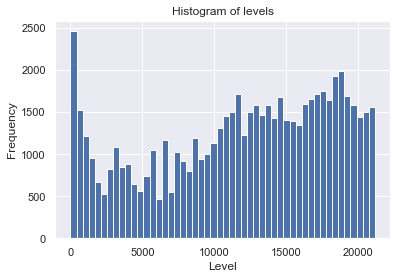

In [ ]:
plt.title('Histogram of levels')
plt.xlabel('Level')
graph_info_df['level'].plot.hist(bins=50)
plt.draw()

Plot of counts for backward topological levels

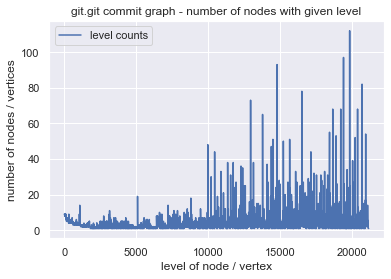

In [ ]:
level_counts=graph_info_df['level'].value_counts()

level_counts_df=pd.DataFrame({'level counts': level_counts})
level_counts_df.index.name='level'
level_counts_df.sort_index(inplace=True)
level_counts_df.plot()

plt.title('%s commit graph - number of nodes with given level' %
          'git.git')
plt.xlabel('level of node / vertex')
plt.ylabel('number of nodes / vertices')
plt.show()

Histogram of counts for backward topological levels

count    21137.000000
mean         3.019776
std          3.477064
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        112.000000
Name: level, dtype: float64

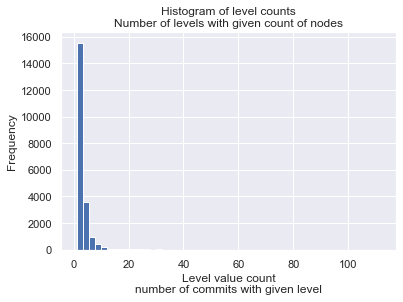

In [ ]:
level_counts=graph_info_df['level'].value_counts()

plt.title('Histogram of level counts\n'+'Number of levels with given count of nodes')
plt.xlabel('Level value count\n'+'number of commits with given level')
level_counts.plot.hist(bins=50)

level_counts.describe()

Sanity checking the computed level counts; nodes with backward topological level of zero are sink nodes, with out-degree of 0.

Thus the number of nodes with level of 0 should be equal to number of nodes with out-degree of 0.

In [ ]:
# sanity checking level counts

print('git.git commit graph')
graph = graph_git

sinks  =[n for n in graph if graph.out_degree(n) == 0]
sources=[n for n in graph if graph.in_degree(n)  == 0]
print('there are {:3d} nodes with  in-degree of 0'.format(len(sources)))
print('there are {:3d} nodes with out-degree of 0: {}'.format(len(sinks),sinks))
print('there are {:3d} nodes with level of 0'.format(level_counts.at[0]))

graph_info_df[graph_info_df['level']==0]

git.git commit graph
there are   3 nodes with  in-degree of 0
there are   9 nodes with out-degree of 0: ['7d77f2e9c', '1bd90415d', '0ca71b373', '16d6b8ab6', 'cb07fc2a2', '161332a52', '2744b2344', '1db95b00a', 'e83c51633']
there are   9 nodes with level of 0


,level,in degree,out degree,degree,f_min,min,post
e83c51633,0,1,0,1,1,1,1
1db95b00a,0,1,0,1,799,799,799
2744b2344,0,1,0,1,1149,1149,1149
161332a52,0,1,0,1,5044,5044,5044
cb07fc2a2,0,1,0,1,8137,8137,8137
16d6b8ab6,0,1,0,1,10300,10300,10300
0ca71b373,0,1,0,1,28384,28384,28384
1bd90415d,0,1,0,1,61749,61749,61749
7d77f2e9c,0,1,0,1,62308,62308,62308


### Visualizing in-degree and out-degree in git.git commit graph

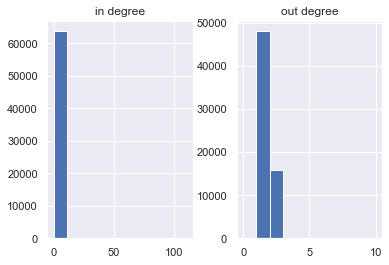

In [ ]:
graph_info_df[['in degree','out degree']].hist(bins=10)
plt.show()

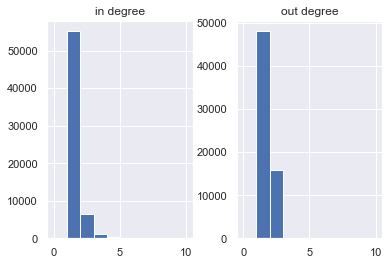

In [ ]:
graph_info_df.hist(column=['in degree','out degree'],bins=10,range=(0,10))
plt.show()

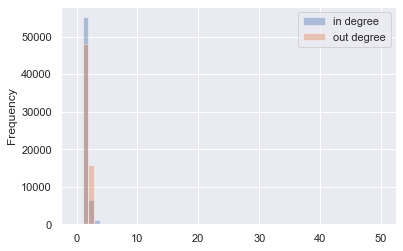

In [ ]:
graph_info_df[['in degree','out degree']].plot.hist(bins=51,alpha=0.4,range=(0,50))
plt.show()

For a graph that follows the power law (for example small-world or scale-free graphs),
the distribution of degrees should be a straight line on log-log scale.

For example the plot below (taken from the KONECT handbook, Figure 7a)
shows the degree distribution and cumulative degree distribution
for the Wikipedia election network ([EL](http://konect.cc/networks/elec/)).

![The degree distribution and cumulative degree distribution for the Wikipedia election network (EL)](images/konect/KONECT_handbook-fig_7a-degree_distribution_Wikipedia_election_network.png)

Below there is the same graph for the commit graph of the git.git repository

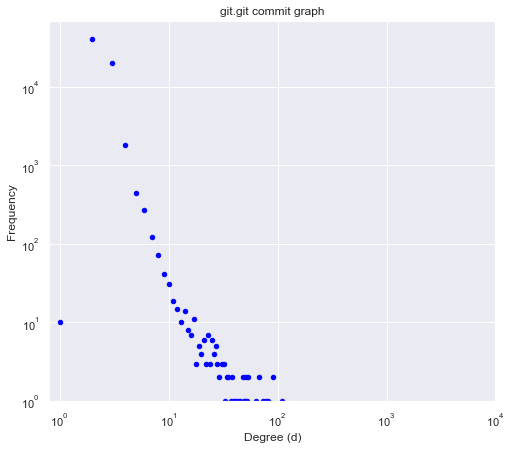

In [ ]:
degree_count_df=graph_info_df['degree'].value_counts(sort=False)\
                    .to_frame(name='Frequency').rename_axis('degree')\
                    .sort_index()
degree_count_df['Degree (d)'] = degree_count_df.index

degree_count_df.plot(kind='scatter',x='Degree (d)',y='Frequency',color='#0000ff',
                     figsize=(8,7),logx=True,logy=True,
                     title='git.git commit graph')
sns.set_style('ticks', {"xtick.major.size": 20, "ytick.major.size": 20})
plt.xlim([.8, 1e4])
plt.ylim([1., 7e4])
plt.show()
#degree_count_df

Note that degrees span the range up to around $10^2$ in the case of git.git commit graph, not $10^4$ of the Wikipedia elections network.
Note also that degree of 1 is an outlier; it does not lie on the line through other points.

Below there is in/outdegree comparison plot for the git.git commit graph

In [ ]:
graph_info_df

,level,in degree,out degree,degree,f_min,min,post
e83c51633,0,1,0,1,1,1,1
8bc9a0c76,1,1,1,2,1,1,2
e497ea2a9,2,1,1,2,1,1,3
bf0c6e839,3,1,1,2,1,1,4
19b2860cb,4,1,1,2,1,1,5
...,...,...,...,...,...,...,...
e6d102643,21094,1,2,3,1,63662,63825
4c6c5054a,21095,1,2,3,1,63662,63826
f29945cb3,21096,1,2,3,1,63662,63827
b16af9417,21097,1,2,3,1,63662,63828


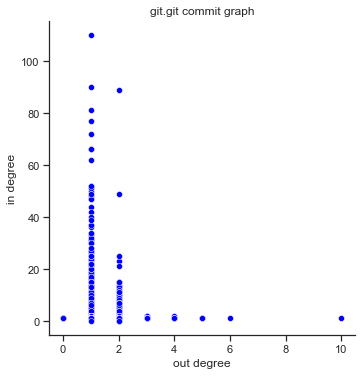

In [ ]:
grid=sns.relplot(data=graph_info_df,x='out degree',y='in degree',
                 kind='scatter',color='#0000ff')
ax=grid.axes[0][0]
ax.set_title('git.git commit graph')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

### Visualizing min-post intervals in git.git commit graphs

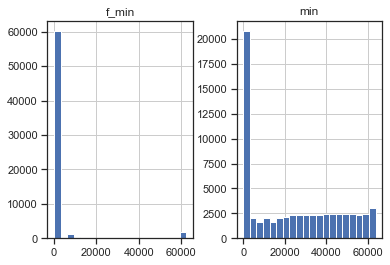

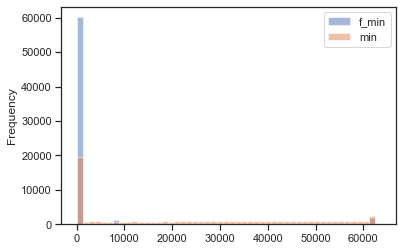

In [ ]:
graph_info_df.hist(column=['f_min','min'],bins=20)
graph_info_df[['f_min','min']].plot.hist(bins=50,alpha=0.5)
plt.show()

Normalized intervals (interval divide by post-visit order number)

In [ ]:
graph_info_df['|interval|']=graph_info_df['post'] - graph_info_df['min']
graph_info_df['|interval|/post']=graph_info_df['|interval|']/graph_info_df['post']
graph_info_df['|f_interval|']=graph_info_df['post'] - graph_info_df['f_min']
graph_info_df['|f_interval|/post']=graph_info_df['|f_interval|']/graph_info_df['post']
graph_info_df

,level,in degree,out degree,degree,f_min,min,post,|interval|,|interval|/post,|f_interval|,|f_interval|/post
e83c51633,0,1,0,1,1,1,1,0,0.000000,0,0.000000
8bc9a0c76,1,1,1,2,1,1,2,1,0.500000,1,0.500000
e497ea2a9,2,1,1,2,1,1,3,2,0.666667,2,0.666667
bf0c6e839,3,1,1,2,1,1,4,3,0.750000,3,0.750000
19b2860cb,4,1,1,2,1,1,5,4,0.800000,4,0.800000
...,...,...,...,...,...,...,...,...,...,...,...
e6d102643,21094,1,2,3,1,63662,63825,163,0.002554,63824,0.999984
4c6c5054a,21095,1,2,3,1,63662,63826,164,0.002569,63825,0.999984
f29945cb3,21096,1,2,3,1,63662,63827,165,0.002585,63826,0.999984
b16af9417,21097,1,2,3,1,63662,63828,166,0.002601,63827,0.999984


In [ ]:
graph_info_df.describe()

,level,in degree,out degree,degree,f_min,min,post,|interval|,|interval|/post,|f_interval|,|f_interval|/post
count,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000,63829.000000
mean,11774.655439,1.248085,1.248085,2.496169,2122.979116,23913.162168,31915.000000,8001.837832,0.303827,29792.020884,0.947877
std,6198.793361,1.556817,0.436128,1.602244,10631.734068,21750.776061,18425.989503,15664.880755,0.458586,18603.735072,0.212082
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7003.000000,1.000000,1.000000,2.000000,1.000000,1.000000,15958.000000,1.000000,0.000037,13660.000000,0.999923
50%,12695.000000,1.000000,1.000000,2.000000,1.000000,21878.000000,31915.000000,7.000000,0.000282,29954.000000,0.999966
75%,17120.000000,1.000000,1.000000,3.000000,1.000000,43554.000000,47872.000000,7365.000000,0.999864,45942.000000,0.999978
max,21136.000000,110.000000,10.000000,111.000000,62308.000000,63662.000000,63829.000000,61747.000000,0.999984,63828.000000,0.999984


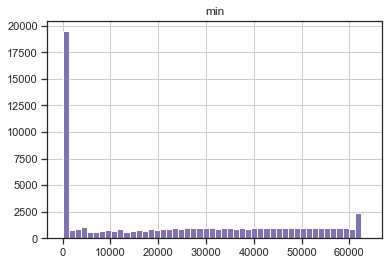

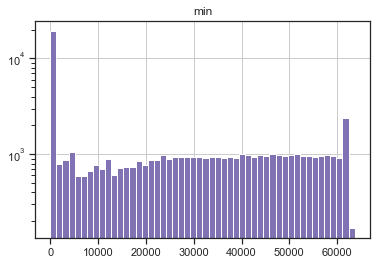

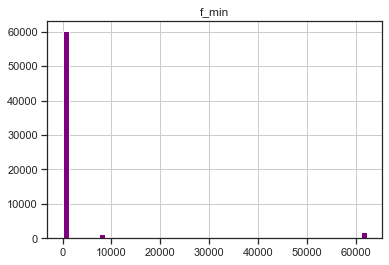

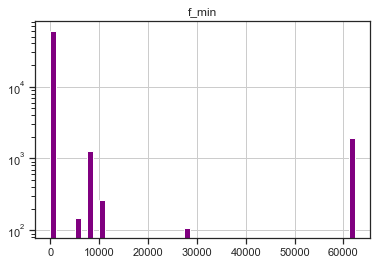

In [ ]:
graph_info_df.hist(column=['min'],bins=50,color='m')
graph_info_df.hist(column=['min'],bins=50,log=True,color='m')
graph_info_df.hist(column=['f_min'],bins=50,color='#800080')
graph_info_df.hist(column=['f_min'],bins=50,log=True,color='#800080')
plt.show()

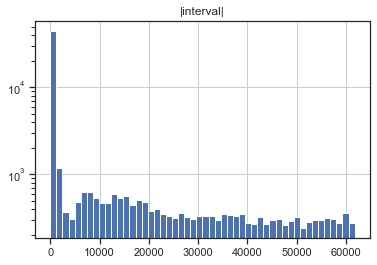

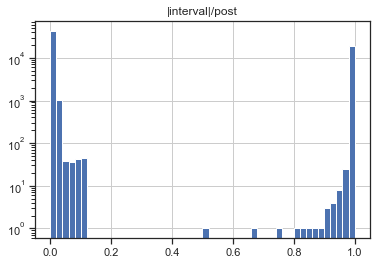

In [ ]:
graph_info_df.hist(column=['|interval|'],bins=50,log=True)
graph_info_df.hist(column=['|interval|/post'],bins=50,log=True)
plt.show()

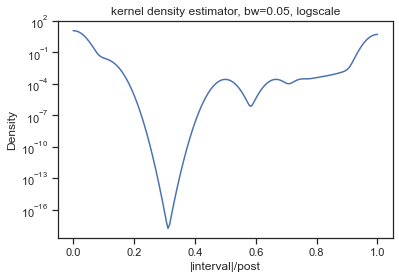

In [ ]:
graph_info_df['|interval|/post'].plot.kde(bw_method=0.05,ind=np.linspace(0,1,200))
plt.title('kernel density estimator, bw=0.05, logscale')
plt.xlabel('|interval|/post')
plt.gca().set_yscale("log", nonpositive='clip')
plt.show()

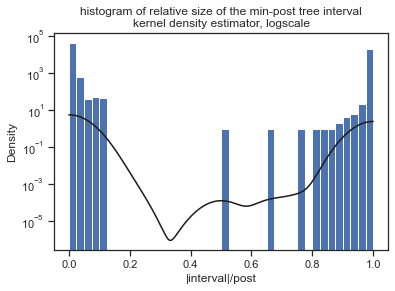

In [ ]:
graph_info_df.hist(column=['|interval|/post'],bins=40,log=True)
graph_info_df['|interval|/post'].plot.kde(ind=np.linspace(0,1,500),color='k')
plt.title('histogram of relative size of the min-post tree interval\n'+'kernel density estimator, logscale')
plt.xlabel('|interval|/post')
plt.gca().set_yscale("log", nonpositive='clip')
plt.show()

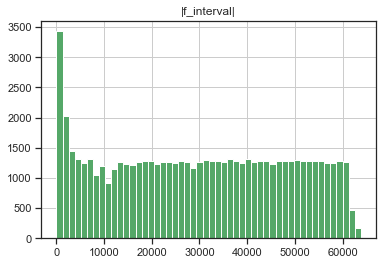

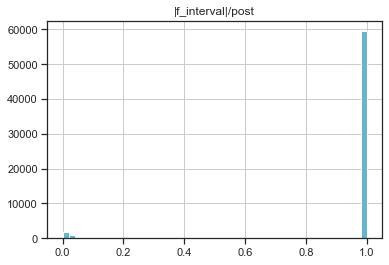

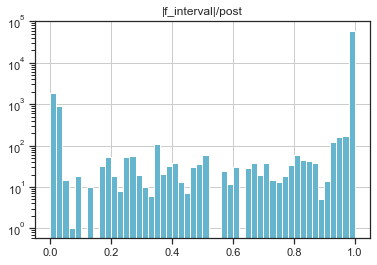

In [ ]:
graph_info_df.hist(column=['|f_interval|'],bins=50,color='g')
graph_info_df.hist(column=['|f_interval|/post'],bins=50,color='c')
graph_info_df.hist(column=['|f_interval|/post'],bins=50,log=True,color='c')
plt.show()

### Storing computed reachability labels and related stats

In [ ]:
from shutil import copyfile
copyfile('datasets/git-commit_graph.df_edgelist.hdf5', 'datasets/git-commit_graph.hdf5')

'datasets/git-commit_graph.hdf5'

In [ ]:
print('pickle.gz: ', end=' ', flush=True)
%time graph_info_df.to_pickle('datasets/git-commit_graph.info.pickle.gz')
print('csv.gz:    ', end=' ', flush=True)
%time graph_info_df.to_csv('datasets/git-commit_graph.info.csv.gz')
print('hdf (full):', end=' ', flush=True)
%time graph_info_df.to_hdf('datasets/git-commit_graph.info.hdf5', 'df', mode='w', complevel=6)
print('hdf (appd):', end=' ', flush=True)
%time graph_info_df.to_hdf('datasets/git-commit_graph.hdf5', 'df_info', mode='a', complevel=6)

pickle.gz:  Wall time: 3.8 s
csv.gz:     Wall time: 2.11 s
hdf (full): Wall time: 316 ms
hdf (appd): Wall time: 321 ms


Saving to `pickle.gz` and `csv.gz` file format takes few seconds, saving to HDF file format takes less than 0.5s

In [ ]:
# feather does not support non-numerical index, IIRC
#%time graph_info_df.to_feather('datasets/git-commit_graph.info.feather')

In [ ]:
%%time
try:
    graph_info_df.to_parquet('datasets/git-commit_graph.info.parquet')
except ImportError:
    print("Missing optional dependency 'pyarrow' required")

Wall time: 468 ms


In [ ]:
["{name:<50} {size:>7}".format(name=p.name,size=p.stat().st_size) for p in Path("datasets").glob("*.info.*")]

['git-commit_graph.info.csv.gz                       1785780',
 'git-commit_graph.info.hdf5                         1382956',
 'git-commit_graph.info.parquet                      3164039',
 'git-commit_graph.info.pickle.gz                    1465333']

In [ ]:
["{name:<50} {size:>7}".format(name=p.name,size=p.stat().st_size) for p in Path("datasets").glob("git-commit_graph.hdf5")]

['git-commit_graph.hdf5                              3803473']

Note that the sizes below are for `git log --all`, not current `git log --branches`, but the relative sizes should be similar

In [ ]:
csv = u"""filename;size [bytes];time [s]
datasets/git-commit_graph.info.pickle.gz;2833650;6.8
datasets/git-commit_graph.info.csv.gz;3681511;5.26
datasets/git-commit_graph.info.parquet;6079159;0.345 
datasets/git-commit_graph.info.hdf5;2735986;0.674
datasets/git-commit_graph.hdf5;6548777;0.672
"""

csv_stream = io.StringIO(csv)
table_sizes_2=pd.read_csv(csv_stream,sep=';') # ,index_col=0
table_sizes_2

,filename,size [bytes],time [s]
0,datasets/git-commit_graph.info.pickle.gz,2833650,6.800
1,datasets/git-commit_graph.info.csv.gz,3681511,5.260
2,datasets/git-commit_graph.info.parquet,6079159,0.345
3,datasets/git-commit_graph.info.hdf5,2735986,0.674
4,datasets/git-commit_graph.hdf5,6548777,0.672


In [ ]:
table_sizes_2.sort_values(by='size [bytes]')

,filename,size [bytes],time [s]
3,datasets/git-commit_graph.info.hdf5,2735986,0.674
0,datasets/git-commit_graph.info.pickle.gz,2833650,6.800
1,datasets/git-commit_graph.info.csv.gz,3681511,5.260
2,datasets/git-commit_graph.info.parquet,6079159,0.345
4,datasets/git-commit_graph.hdf5,6548777,0.672


In [ ]:
table_sizes_2.sort_values(by='time [s]')

,filename,size [bytes],time [s]
2,datasets/git-commit_graph.info.parquet,6079159,0.345
4,datasets/git-commit_graph.hdf5,6548777,0.672
3,datasets/git-commit_graph.info.hdf5,2735986,0.674
1,datasets/git-commit_graph.info.csv.gz,3681511,5.260
0,datasets/git-commit_graph.info.pickle.gz,2833650,6.800


### Summary of findings

Strangely,smallest files size this time is given when storing using the **_HDF5_** (with `compresslevel=6`) format, which is also 2nd fastest.

Saving `DataFrame` using the **_Parquet_** format is fastest, but this time it gives the largest size of the file (except for `git-commit_graph.hdf5`, which stores both commit graph in edge list format, and per-node information)

Saving as **\*.pickle.gz** or **\*.csv.gz** is slowest and second slowest, while both being in the middlle with respect to file sizes (the pickle-based format gives smaller file size).